In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers


2023-05-16 18:14:05.984289: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-16 18:14:06.037751: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-16 18:14:06.038935: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 18:14:07.133253: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
x_df = pd.read_csv('/home/oleg/Documents/matmod_challeng/X.csv')
y_df = pd.read_csv('/home/oleg/Documents/matmod_challeng/y.csv')


x_vals = x_df.columns
predicted_cols = y_df.columns


merged_df = pd.merge(x_df, y_df, on=["engine_id", "flight_datetime", "flight_phase"])

merged_df = merged_df.dropna(axis=1, how='all')

merged_df = merged_df.drop(x_vals.intersection(predicted_cols) , axis=1)
merged_df = merged_df.dropna(axis=1, how='all')
merged_df = merged_df.fillna(0)
merged_df = merged_df.loc[:,merged_df.apply(pd.Series.nunique) != 1]


to_rm = [  'aircraft_id',  'engine_position', 'number_blades', 'engine_family', 'engine_type', 'manufacturer', 'aircraft_family', 'aircraft_grp', 'ac_manufacturer', 'aircraft_type', ]
merged_df = merged_df.drop(to_rm, axis=1)


In [4]:
x_vals = x_vals.drop(to_rm).drop(['engine_id', 'flight_datetime', 'flight_phase'])
predicted_cols = predicted_cols.drop(['engine_id', 'flight_datetime', 'flight_phase'])


x_vals = x_vals.intersection(merged_df.columns)
predicted_cols = predicted_cols.intersection(merged_df.columns)

In [5]:
train_dataset = merged_df.sample(frac=0.8, random_state=0)
test_dataset = merged_df.drop(train_dataset.index)


In [6]:


train_features = train_dataset[x_vals]
test_features = test_dataset[x_vals]

train_labels = train_dataset['ZTLA_D']
test_labels = test_dataset['ZTLA_D']



from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.fit_transform(test_features)



In [7]:


normalizer = tf.keras.layers.Normalization()
normalizer.adapt(train_features)


In [8]:

train = np.array(train_features)

train_normalizer = layers.Normalization()
train_normalizer.adapt(train)

In [9]:
train_model = tf.keras.Sequential([
    train_normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),

    layers.Dense(1)
])


In [10]:
train_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='mean_absolute_error')

598/598 [==============================] - 1s 1ms/step


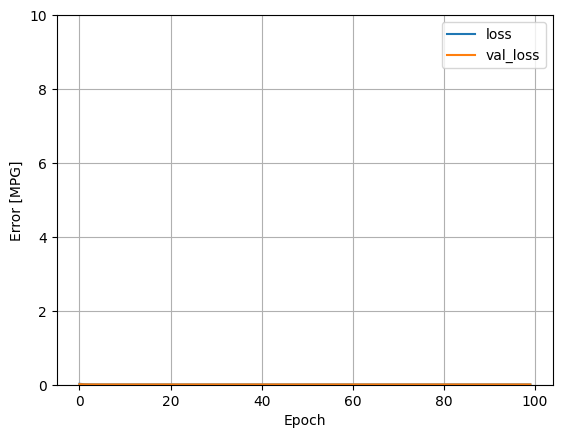

In [11]:
history = train_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)


pred = train_model.predict(test_features)

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [12]:
from sklearn.metrics import r2_score


print(r2_score(test_labels , pred))

0.19996408014729194
